# Bayesian Logistic Regression on the Kaggle titanic dataset

In [1]:
%matplotlib inline
import pandas as pd
import seaborn
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [10]:
import qgrid
qgrid.nbinstall()

In [11]:
from pymc3 import Model, Normal, Bernoulli, find_MAP, NUTS, sample, sum, traceplot

## Load dataset

In [12]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

## Fill in missing values in Age column

In [13]:
mean_age = np.mean(train_data.loc[~np.isnan(train_data['Age']), 'Age'])
train_data.loc[np.isnan(train_data['Age']), 'Age'] = mean_age
test_data.loc[np.isnan(test_data['Age']), 'Age'] = mean_age

In [15]:
qgrid.show_grid(train_data, remote_js=True)

## Prepare the training data

In [7]:
y = train_data["Survived"]

In [8]:
x = train_data[["Pclass", "Age"]]
x.loc[:, "Intercept"] = 1
x.loc[:, "Sex"] = ((train_data["Sex"] == "male") * 1)

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Build the model

In [8]:
import theano.tensor as t
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [9]:
logistic_model = Model()

with logistic_model:
    effects = Normal('effects', mu=0, tau=2. ** -2, shape=(1, x.shape[1]))
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Bernoulli('Y_obs', p=p, observed=y)

In [10]:
with logistic_model:
    # move the chain to the MAP which should be a good starting point
    start = find_MAP()
    step = NUTS(scaling=start)
    trace = sample(5000, step, start)

 [-----------------100%-----------------] 5000 of 5000 complete in 61.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8eb2e3ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa8eb0b2d30>]], dtype=object)

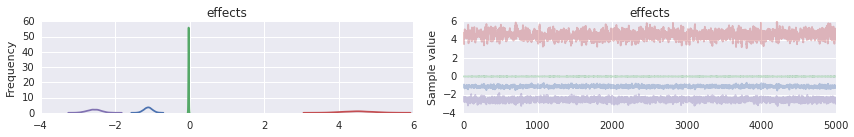

In [11]:
traceplot(trace)

In [12]:
trace['effects']

array([[[-1.09676879, -0.02903348,  4.48974061, -2.45753634]],

       [[-1.09676879, -0.02903348,  4.48974061, -2.45753634]],

       [[-1.16002106, -0.0338922 ,  4.51968149, -2.55373352]],

       ..., 
       [[-1.24548209, -0.03337827,  5.10623622, -3.00418852]],

       [[-1.13716367, -0.03495873,  4.4685661 , -2.53877428]],

       [[-1.13443239, -0.02604646,  4.49673206, -2.44640603]]])

## Prepare the testing data

In [13]:
new_x = test_data[["Pclass", "Age"]]
new_x.loc[:, "Intercept"] = 1
new_x.loc[:, "Sex"] = (test_data["Sex"] == "male") * 1
# new_x = new_x.drop("Pclass", 1)

In [14]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

## Take average of all the eta's implied by the samples

In [15]:
eta = np.zeros(new_x.shape[0])
for row in trace['effects']:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'].shape[0])

In [16]:
p = invlogit(eta)
p[:20]

array([ 0.07725205,  0.42751563,  0.09950293,  0.09527585,  0.61603883,
        0.13550032,  0.5567653 ,  0.24945878,  0.64454149,  0.11231489,
        0.0883926 ,  0.35559176,  0.93581827,  0.09679533,  0.87495842,
        0.8220575 ,  0.20152091,  0.11231489,  0.57927939,  0.44255144])

## Prepare Submission

In [17]:
prediction = pd.DataFrame({'Survived_p':p})

In [18]:
prediction["PassengerId"] = test_data["PassengerId"]
prediction['Survived'] = (prediction['Survived_p']>0.5) * 1

In [19]:
prediction.drop('Survived_p', 1).to_csv('output.csv', index=False)

In [20]:
prediction['Sex'] = test_data["Sex"]

In [21]:
prediction.head()

,Survived_p,PassengerId,Survived,Sex
0,0.077,892,0,male
1,0.428,893,0,female
2,0.100,894,0,male
3,0.095,895,0,male
4,0.616,896,1,female
